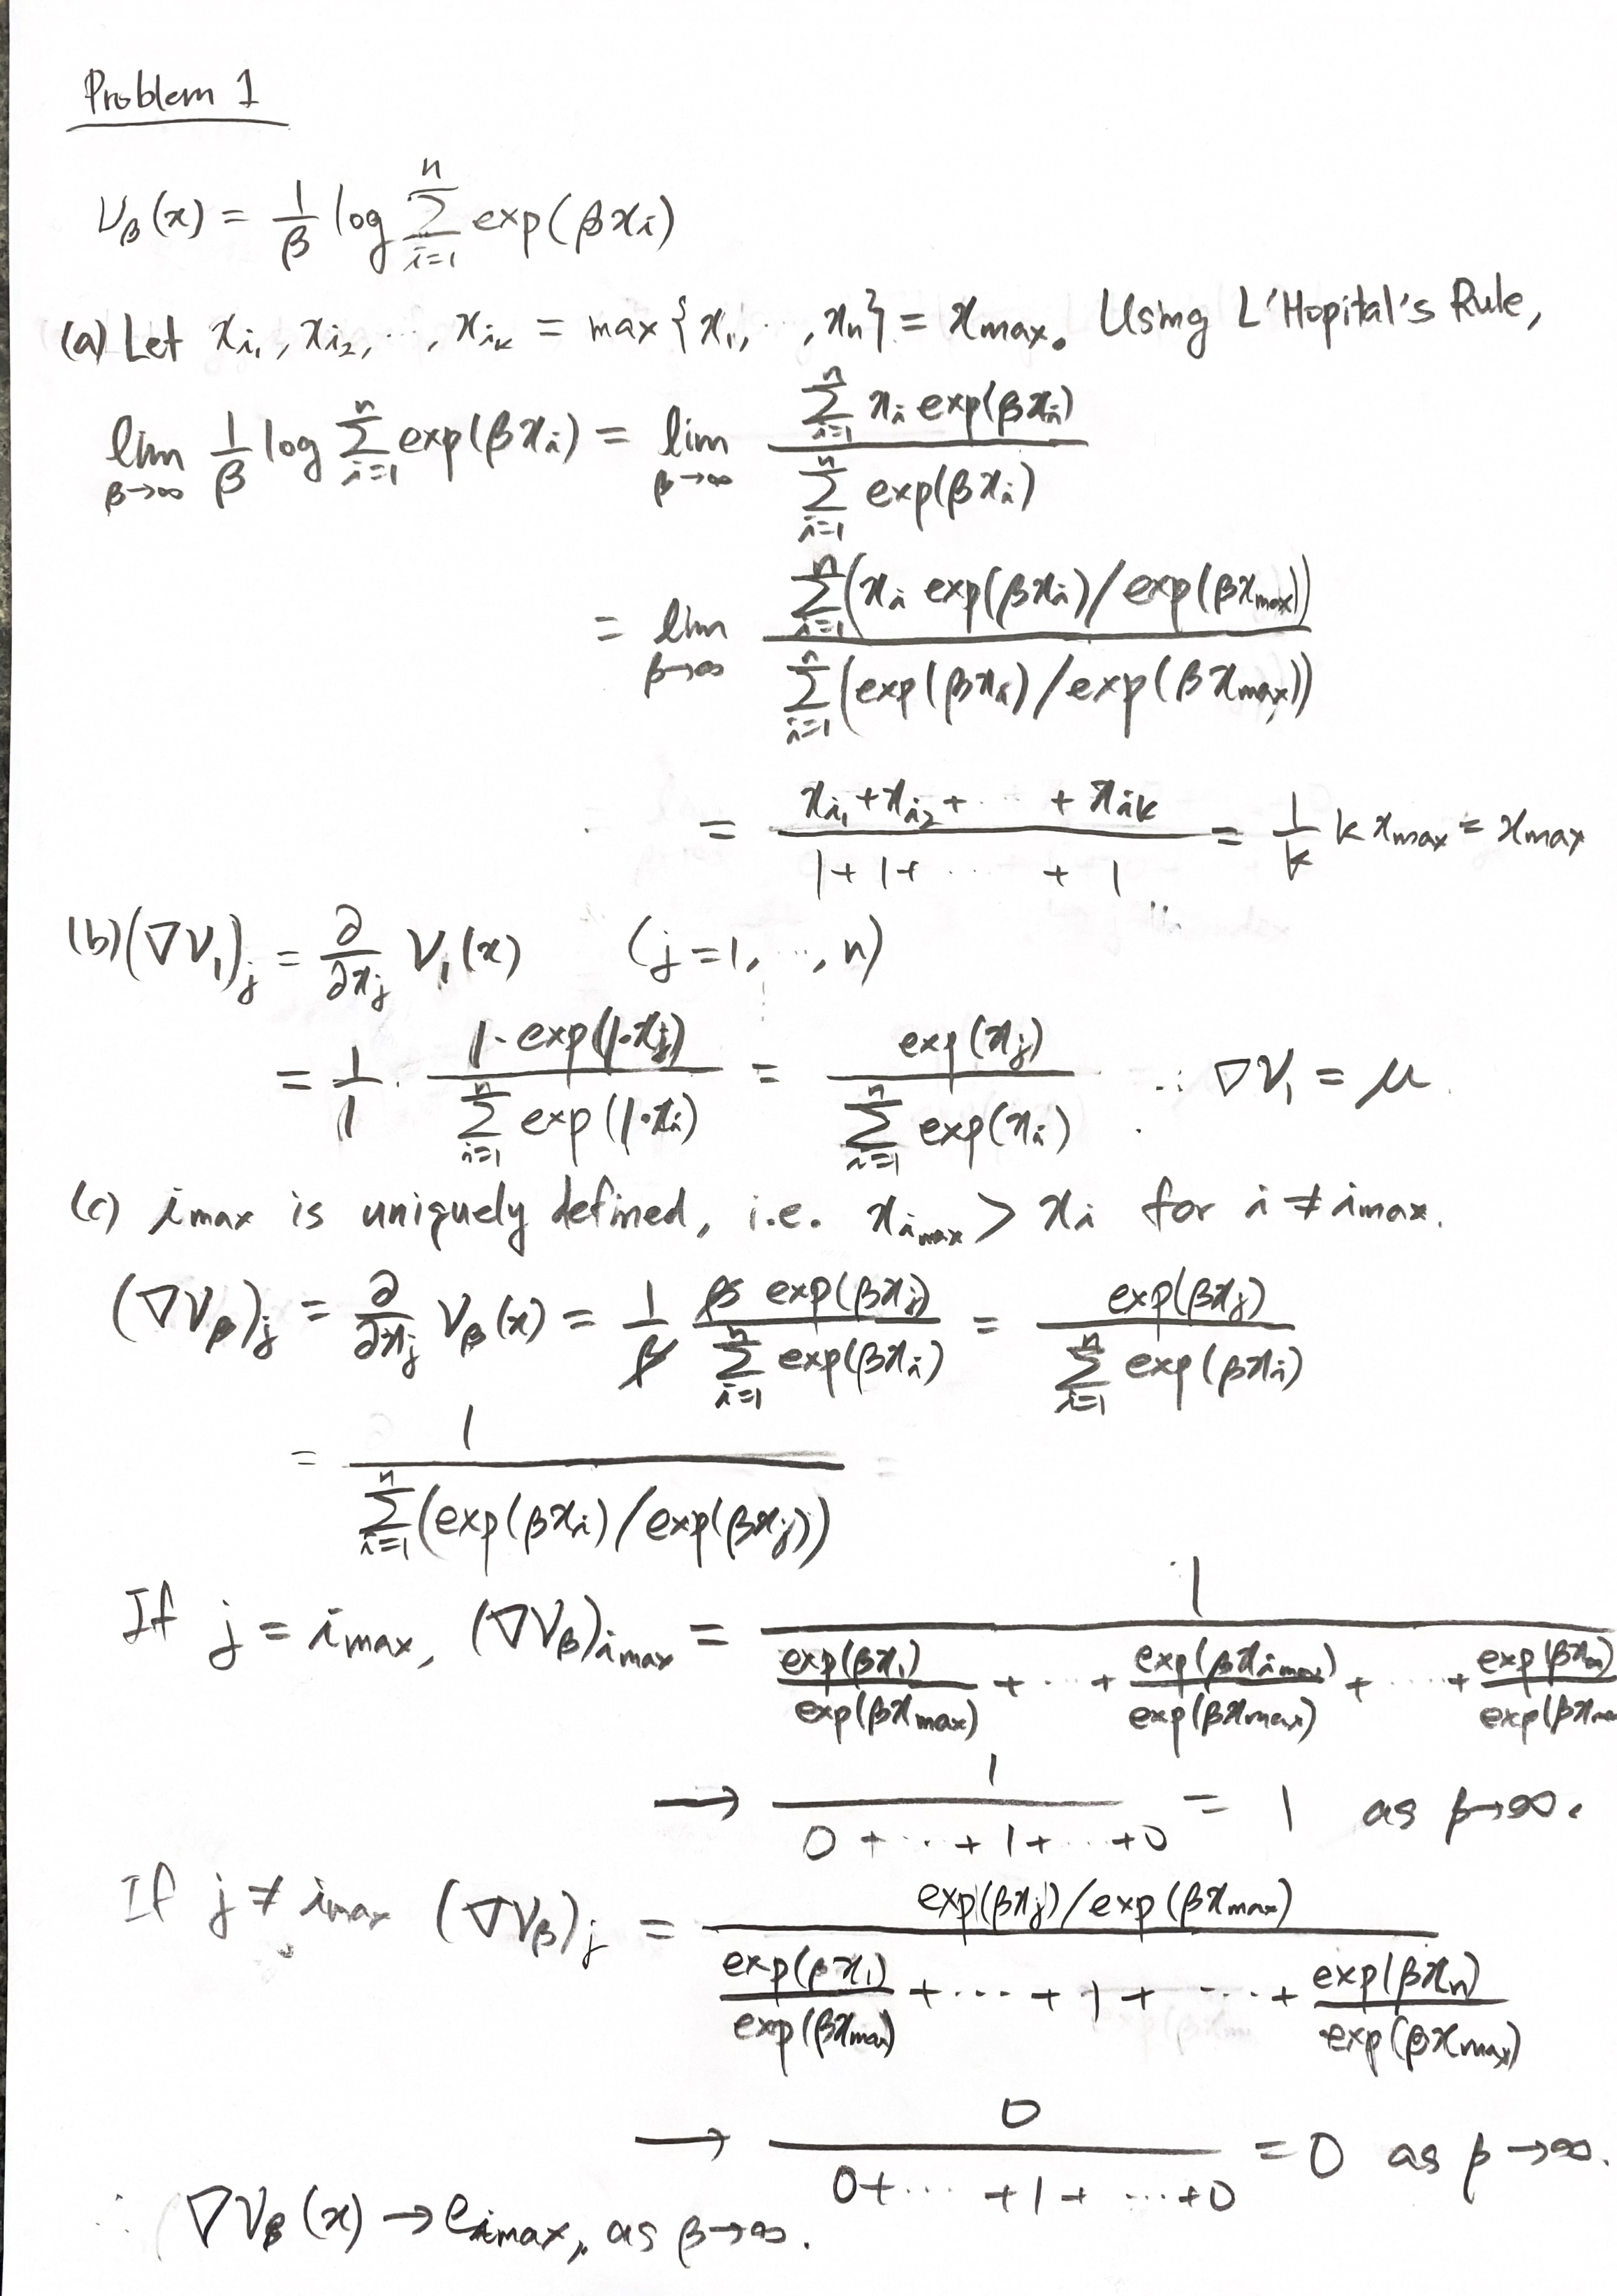

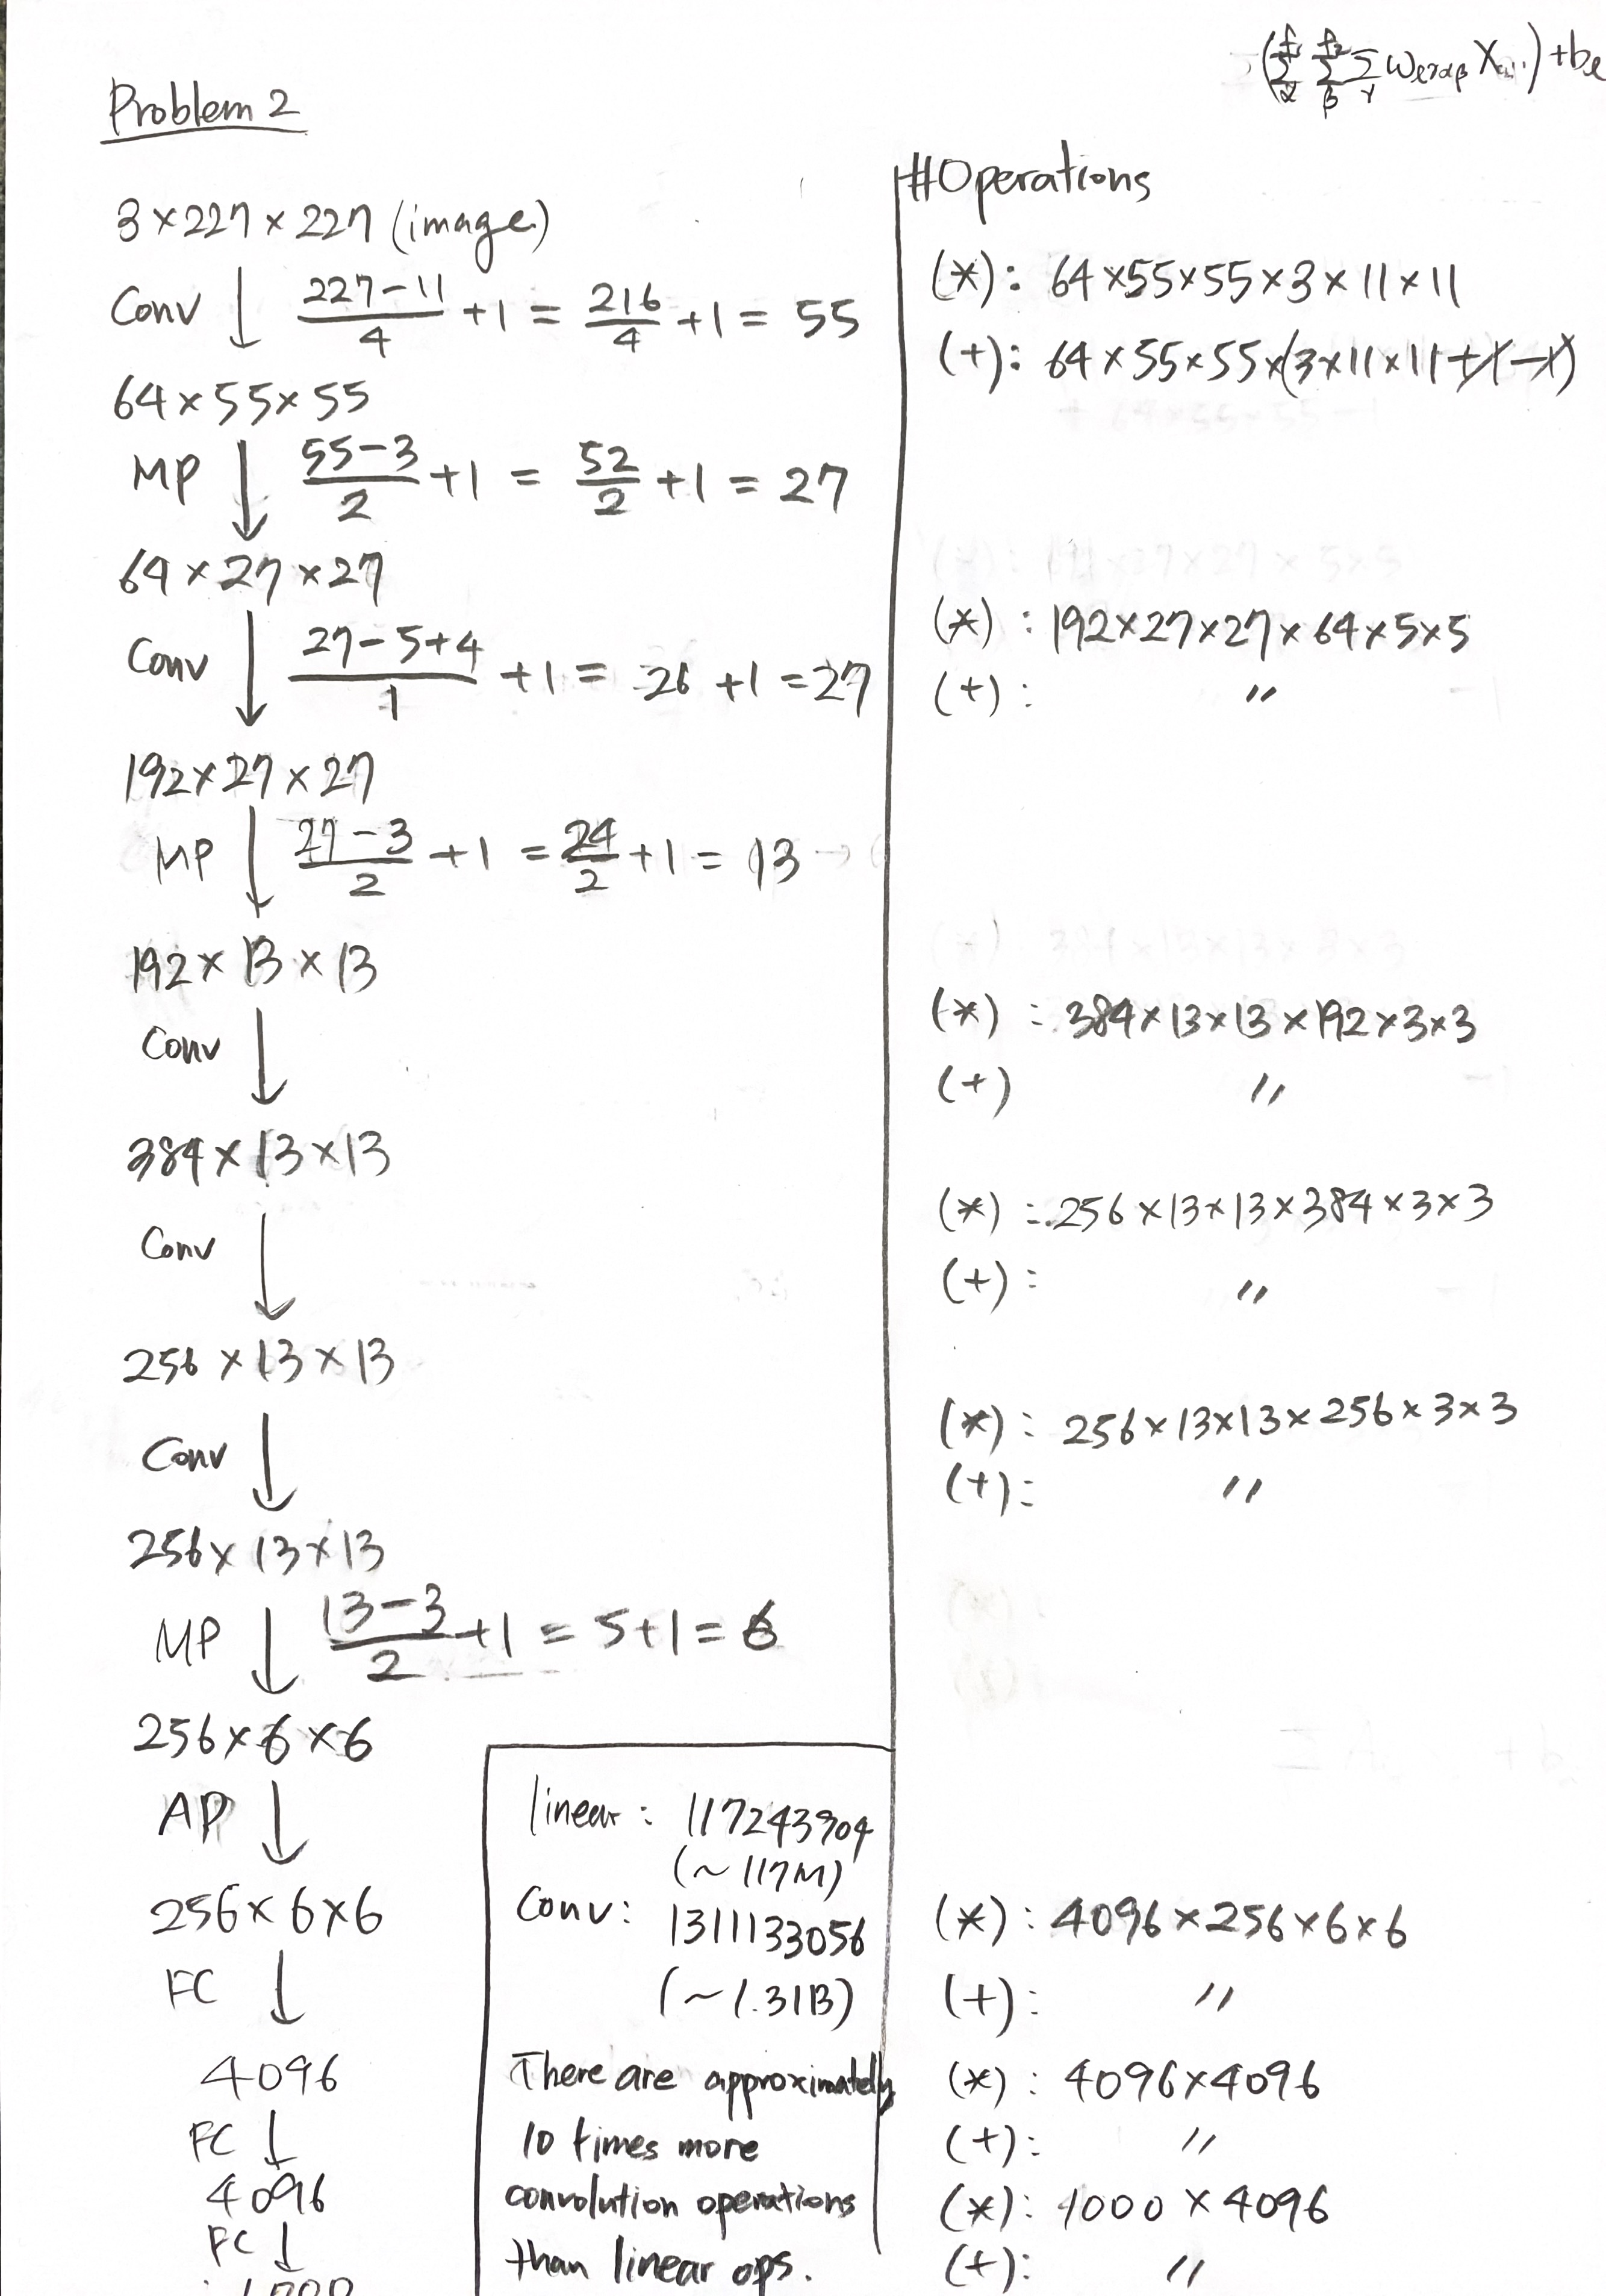

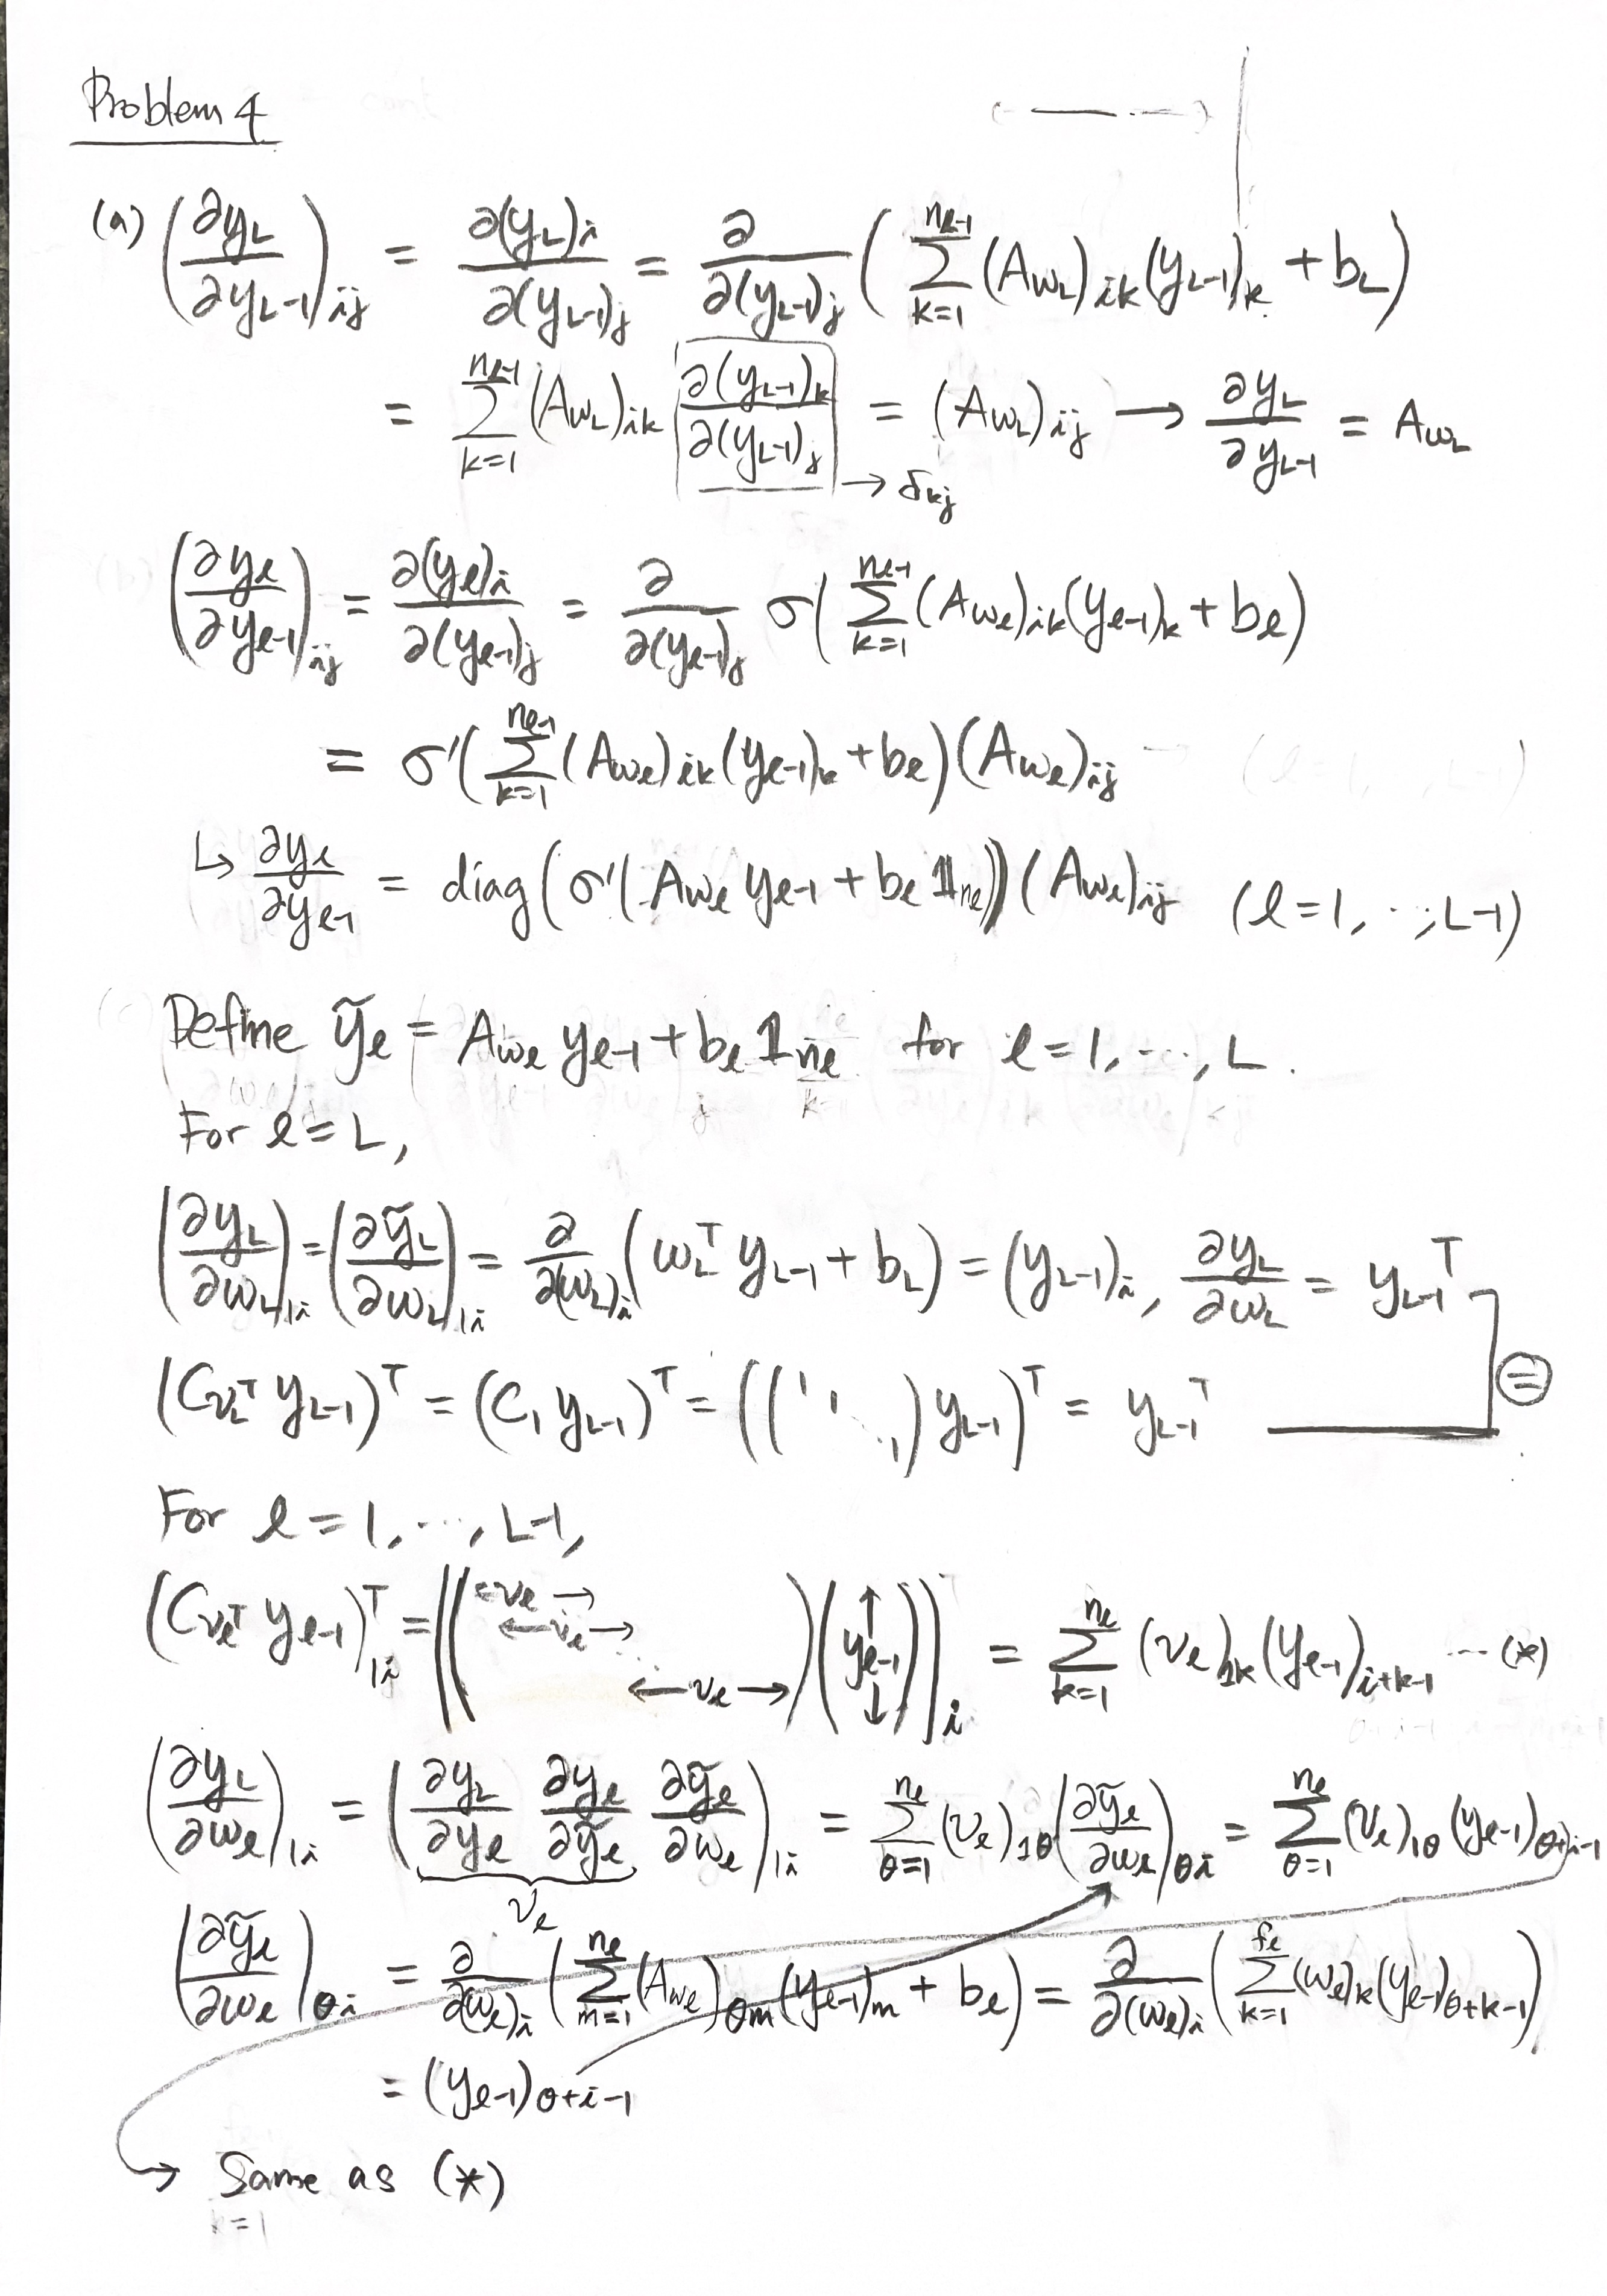

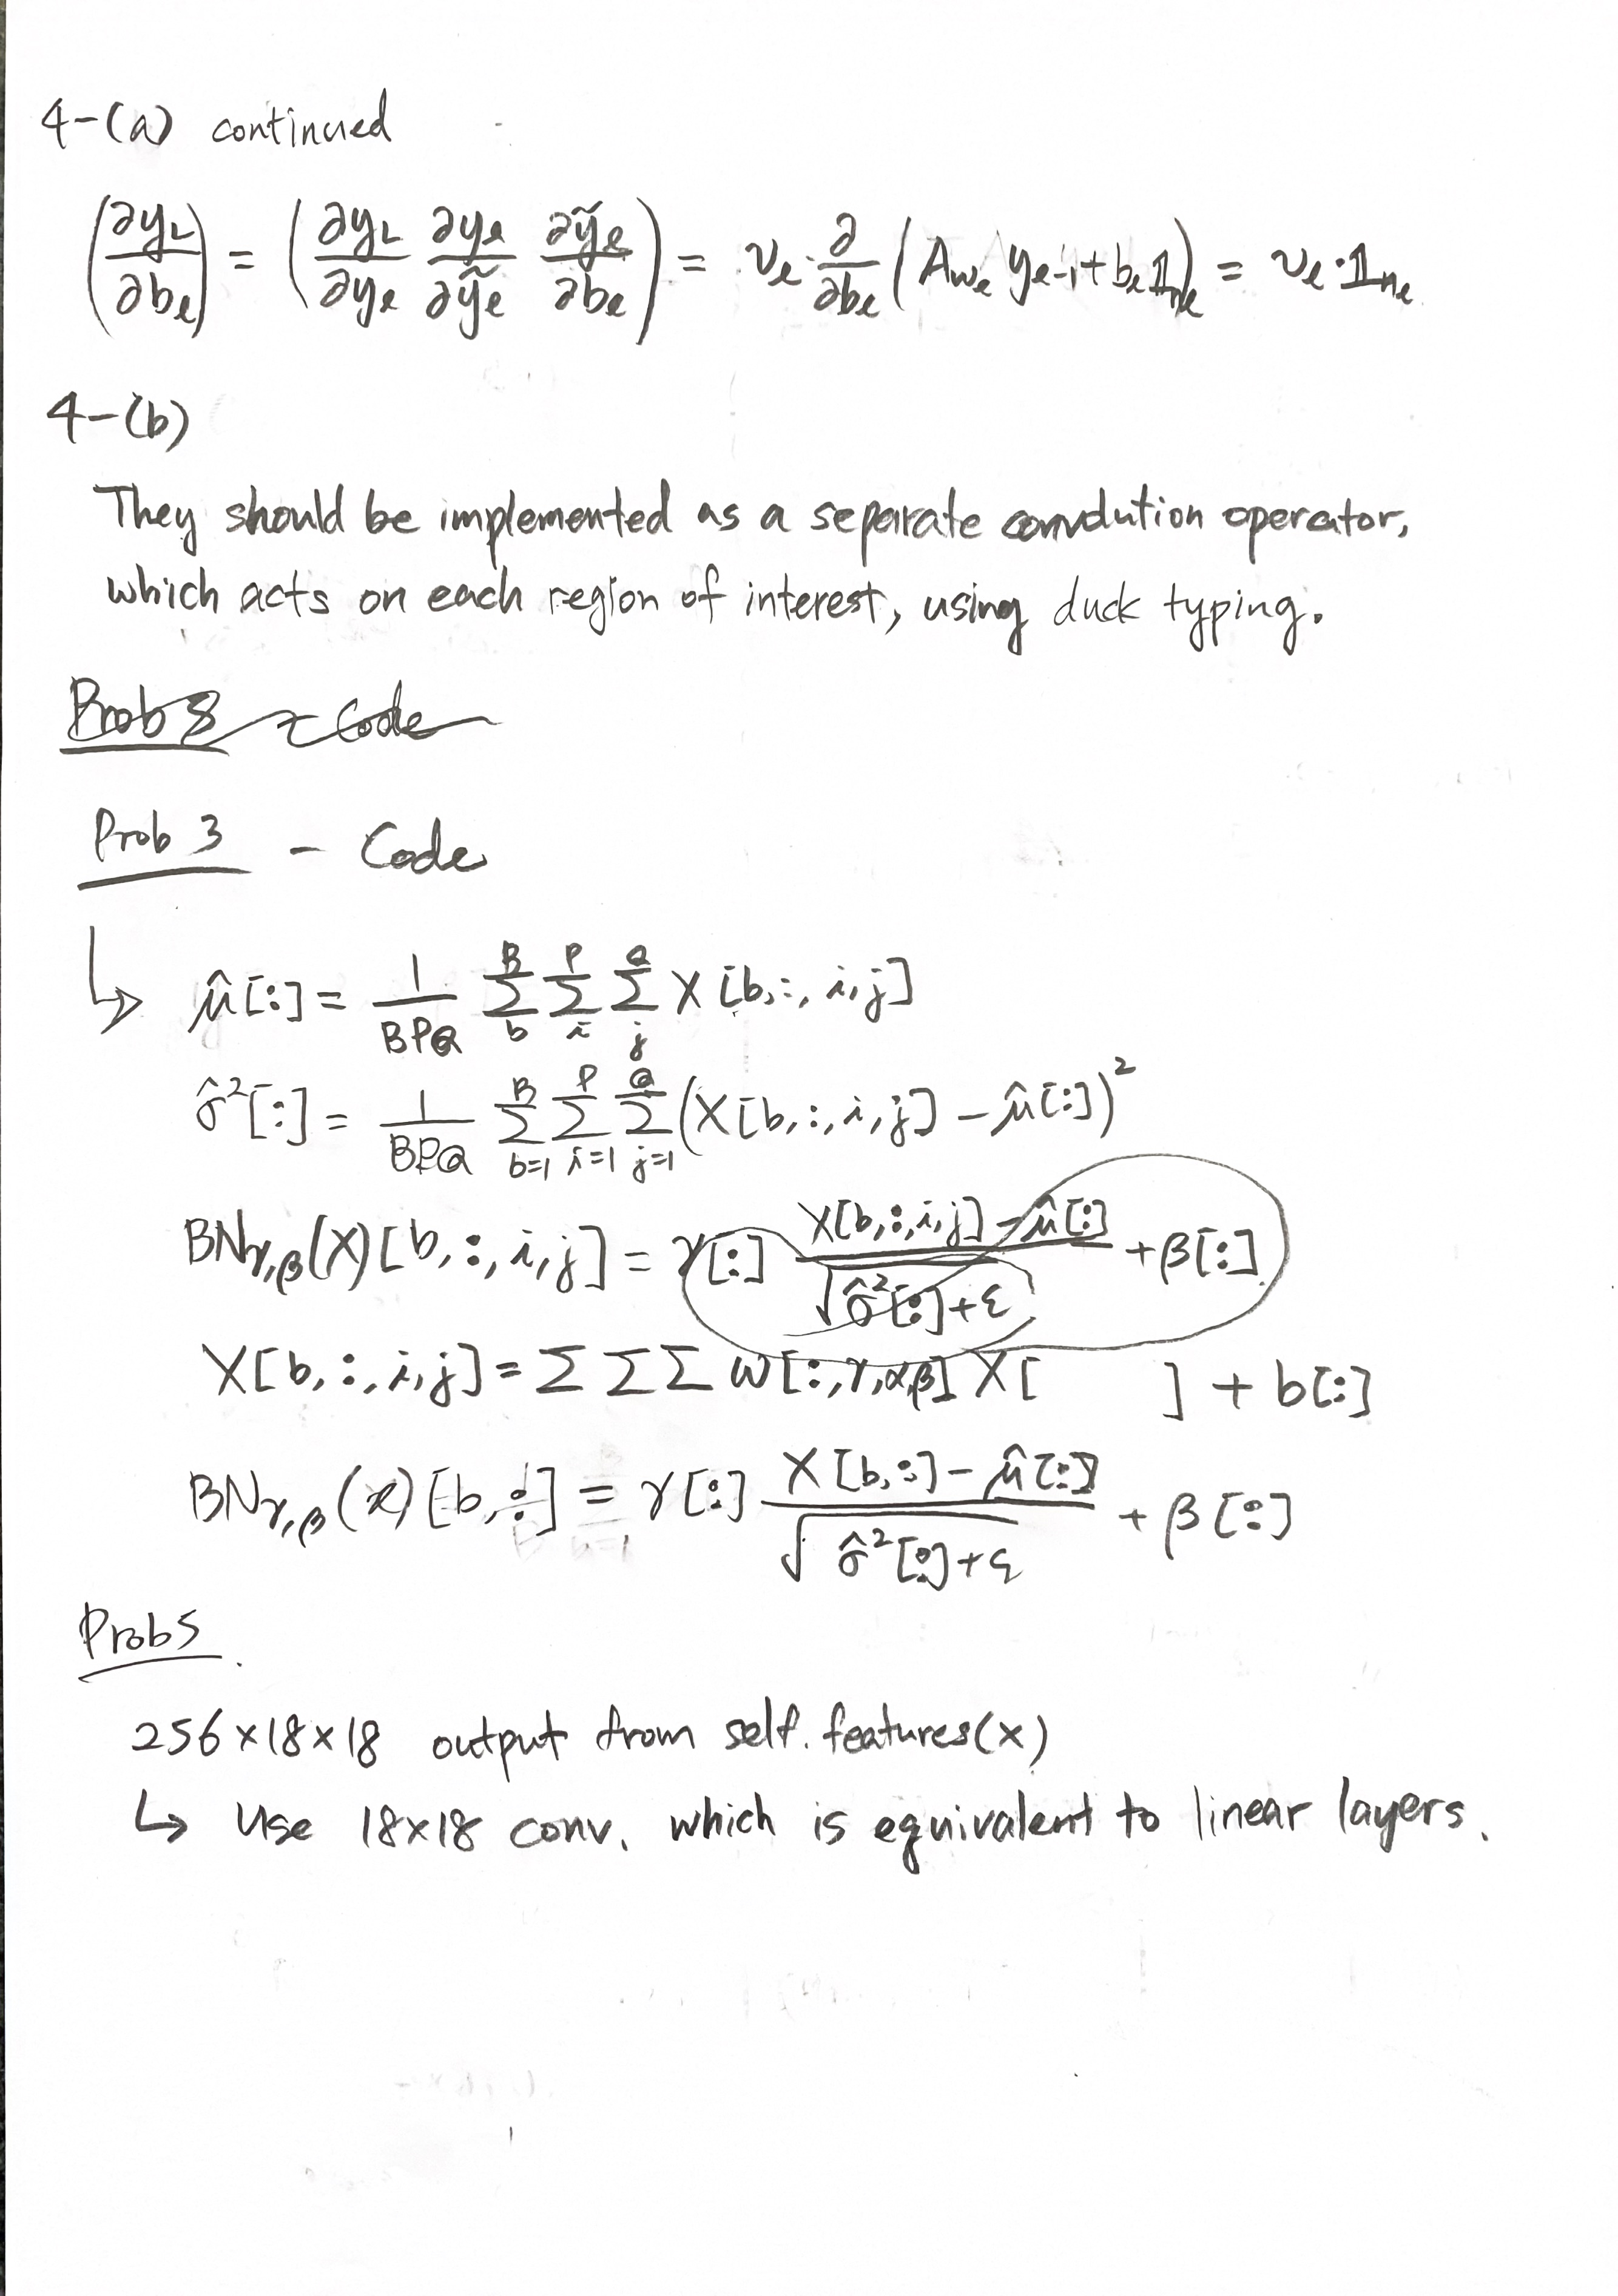

# Problem 3 - Removing BN after training, BNremove.py

In [21]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms


# Instantiate model with BN and load trained parameters
class smallNetTrain(nn.Module) :
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()

        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=3, padding=1),
                            nn.BatchNorm2d(16),
                            nn.ReLU()
                            )      
        self.conv2 = nn.Sequential(
                            nn.Conv2d(16, 16, kernel_size=3, padding=1),
                            nn.BatchNorm2d(16),
                            nn.ReLU()
                            ) 
        self.fc1 = nn.Sequential(
                            nn.Linear(16*32*32, 32*32),
                            nn.BatchNorm1d(32*32),
                            nn.ReLU()
                            )   
        self.fc2 = nn.Sequential(
                            nn.Linear(32*32, 10),
                            nn.ReLU()
                            )   

    def forward(self, x) :
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.float().view(-1, 16*32*32)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

    
model = smallNetTrain()
model.load_state_dict(torch.load("./smallNetSaved",map_location=torch.device('cpu')))


# Instantiate model without BN
class smallNetTest(nn.Module) :
    # CIFAR-10 data is 32*32 images with 3 RGB channels
    def __init__(self, input_dim=3*32*32) :
        super().__init__()

        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=3, padding=1),
                            nn.ReLU()
                            )      
        self.conv2 = nn.Sequential(
                            nn.Conv2d(16, 16, kernel_size=3, padding=1),
                            nn.ReLU()
                            ) 
        self.fc1 = nn.Sequential(
                            nn.Linear(16*32*32, 32*32),
                            nn.ReLU()
                            )   
        self.fc2 = nn.Sequential(
                            nn.Linear(32*32, 10),
                            nn.ReLU()
                            )   

    def forward(self, x) :
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.float().view(-1, 16*32*32)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    
model_test = smallNetTest()



# Initialize weights of model without BN

conv1_bn_beta, conv1_bn_gamma = model.conv1[1].bias, model.conv1[1].weight
conv1_bn_mean, conv1_bn_var = model.conv1[1].running_mean, model.conv1[1].running_var
conv2_bn_beta, conv2_bn_gamma = model.conv2[1].bias, model.conv2[1].weight
conv2_bn_mean, conv2_bn_var = model.conv2[1].running_mean, model.conv2[1].running_var
fc1_bn_beta, fc1_bn_gamma = model.fc1[1].bias, model.fc1[1].weight
fc1_bn_mean, fc1_bn_var = model.fc1[1].running_mean, model.fc1[1].running_var
eps = 1e-05


# print(conv1_bn_gamma.shape)
# print(model.conv1[0].weight.data.shape)

model_test.conv1[0].bias.data = (model.conv1[0].bias - conv1_bn_mean) * (conv1_bn_gamma / torch.sqrt(conv1_bn_var+eps)) + conv1_bn_beta
model_test.conv1[0].weight.data = model.conv1[0].weight.data * (conv1_bn_gamma / torch.sqrt(conv1_bn_var+eps)) [:, None, None, None]

model_test.conv2[0].bias.data = (model.conv2[0].bias - conv2_bn_mean) * (conv2_bn_gamma / torch.sqrt(conv2_bn_var+eps)) + conv2_bn_beta
model_test.conv2[0].weight.data = model.conv2[0].weight.data * (conv2_bn_gamma / torch.sqrt(conv2_bn_var+eps)) [:, None, None, None]

model_test.fc1[0].bias.data = (model.fc1[0].bias - fc1_bn_mean) * (fc1_bn_gamma / torch.sqrt(fc1_bn_var+eps)) + fc1_bn_beta
model_test.fc1[0].weight.data = model.fc1[0].weight.data * (fc1_bn_gamma / torch.sqrt(fc1_bn_var+eps)) [:, None]

model_test.fc2[0].bias.data = model.fc2[0].bias.data
model_test.fc2[0].weight.data = model.fc2[0].weight.data



# Verify difference between model and model_test

model.eval()  
# model_test.eval()  # not necessary since model_test has no BN or dropout 


test_dataset = torchvision.datasets.CIFAR10(root='./cifar_10data/',
                                train=False, 
                                transform=transforms.ToTensor(), download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

diff = []
with torch.no_grad():
    for images, _ in test_loader:
        diff.append(torch.norm(model(images) - model_test(images))**2) 
        
print(max(diff)) # If less than 1e-08, you got the right answer.



'''
For debugging purposes, you may want to match the output of conv1 first before
moving on working on conv2. To do so, you can replace the forward-evaluation
functions of the two models with 
def forward(self, x) :
    x = self.conv1(x)
    return x
'''

Files already downloaded and verified
tensor(7.2020e-09)


'\nFor debugging purposes, you may want to match the output of conv1 first before\nmoving on working on conv2. To do so, you can replace the forward-evaluation\nfunctions of the two models with \ndef forward(self, x) :\n    x = self.conv1(x)\n    return x\n'

# Problem 5 - Large Network-in-Network, LNiN.py

In [38]:
import torch.nn as nn
import torch
import torchvision


class Net1(nn.Module):
    def __init__(self, num_classes=10):
        super(Net1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(192, 384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 18 * 18, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class Net2(nn.Module):
    def __init__(self, num_classes=10):
        super(Net2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(192, 384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1),
        )

    ###########################################################  
    ### TODO: Complete initialization of self.classifier    ###
    ###        by filling in ... COMPLETE!                  ###
    ###########################################################
        self.classifier = nn.Sequential(
            nn.Conv2d(256, 4096, kernel_size=18, stride=1),
            nn.ReLU(),
            nn.Conv2d(4096, 4096, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(4096, num_classes, kernel_size=1, stride=1)
        )
        
        self.num_classes = num_classes

    def copy_weights_from(self, net1):
        with torch.no_grad():
            for i in range(0, len(self.features), 2):
                self.features[i].weight.copy_(net1.features[i].weight)
                self.features[i].bias.copy_(net1.features[i].bias)
            
            for i in range(len(self.classifier)):
                ####################################################
                ### TO DO: Correctly transfer weight of Net1     ###
                ###        ... COMPLELTE!                        ###
                ####################################################
                self.classifier[0].weight.data = net1.classifier[0].weight.data.reshape((4096, 256, 18, 18))
                self.classifier[0].bias.data = net1.classifier[0].bias.data.reshape((4096, ))
                self.classifier[2].weight.data = net1.classifier[2].weight.data.reshape((4096, 4096, 1, 1))
                self.classifier[2].bias.data = net1.classifier[2].bias.data.reshape((4096, ))
                self.classifier[4].weight.data = net1.classifier[4].weight.data.reshape((self.num_classes, 4096, 1, 1))
                self.classifier[4].bias.data = net1.classifier[4].bias.data.reshape((self.num_classes, ))

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



model1 = Net1() # model1 randomly initialized
model2 = Net2()
model2.copy_weights_from(model1)

test_dataset = torchvision.datasets.CIFAR10(
    root='./cifar_10data',
    train=False,
    transform=torchvision.transforms.ToTensor(), 
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=10
)

imgs, _ = next(iter(test_loader))
diff = torch.mean((model1(imgs) - model2(imgs).squeeze()) ** 2)
print(f"Average Pixel Difference: {diff.item()}") # should be small


test_dataset = torchvision.datasets.CIFAR10(
    root='./cifar_10data',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((36, 38)),
        torchvision.transforms.ToTensor()
        ])
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=10,
    shuffle=False
)

images, _ = next(iter(test_loader))
b, w, h = images.shape[0], images.shape[-1], images.shape[-2]
out1 = torch.empty((b, 10, h - 31, w - 31))
for i in range(h - 31):
    for j in range(w - 31):
        ########################################################
        ### TO DO: fill in ... to make out1 and out2 equal   ###
        ########################################################
        out1[:, :, i, j] = model1(...)
out2 = model2(images)
diff = torch.mean((out1 - out2) ** 2)

print(f"Average Pixel Diff: {diff.item()}")


Average Pixel Difference: 7.345419426008049e-17


TypeError: conv2d() received an invalid combination of arguments - got (ellipsis, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!ellipsis!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!ellipsis!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


### describe how Net2 applied to X is equivalent to Net1 applied to patches of X.  
I do not know the answer to this yet.